Instructions for updating:
non-resource variables are not supported in the long term
INFO:tensorflow:Summary name Learning rate is illegal; using Learning_rate instead.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter: 0
iter: 1000
iter: 2000
iter: 3000
iter: 4000
iter: 5000
iter: 6000
iter: 7000
iter: 8000
iter: 9000
iter: 10000
iter: 11000
iter: 12000
iter: 13000
iter: 14000
iter: 15000
iter: 16000
iter: 17000
iter: 18000
iter: 19000
iter: 20000
iter: 21000
iter: 22000
iter: 23000
iter: 24000
iter: 25000
iter: 26000
iter: 27000
iter: 28000
iter: 29000
iter: 30000
iter: 31000
iter: 32000
iter: 33000
iter: 34000
iter: 35000
iter: 36000
iter: 37000
iter: 38000
iter: 39000
iter: 40000
iter: 41000
iter: 42000
iter: 43000
iter: 44000
iter: 45000
iter: 46000
iter: 47000
iter: 48000
iter: 49000
iter: 50000
iter: 51000
iter: 52000
iter: 53000
iter: 54000
iter: 55000
iter: 56000
iter: 57000
iter: 58000
iter: 59000
iter: 60000
iter: 61000
iter: 62000
iter: 63000
iter: 64000
iter: 65000
iter: 66000
iter: 67000
iter: 68000
iter: 69000
iter: 70000
iter: 71000
iter: 72000
iter: 73000
iter: 74000
iter: 75000
iter: 76000
iter: 77000
iter: 78000
iter: 79000
iter: 80000
iter: 81000
iter: 82000
iter: 83000
iter:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


219.1323881149292


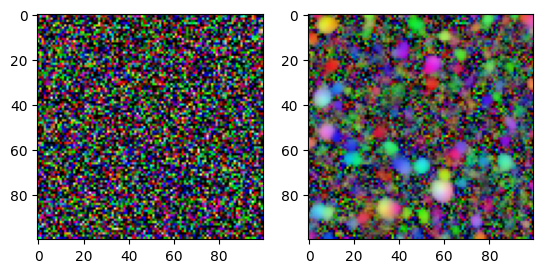

In [2]:
import time
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt

class SOMNetwork():
    def __init__(self, input_dim, dim=10, sigma=None, learning_rate=0.1, tay2=1000, dtype=tf.float32):
        #если сигма на определена устанавливаем ее равной половине размера решетки
        if not sigma:
            sigma = dim / 2
        self.dtype = dtype
        #определяем константы использующиеся при обучении
        self.dim = tf.constant(dim, dtype=tf.int64)
        self.learning_rate = tf.constant(learning_rate, dtype=dtype, name='learning_rate')
        self.sigma = tf.constant(sigma, dtype=dtype, name='sigma')
        self.tay1 = tf.constant(1000/np.log(sigma), dtype=dtype, name='tay1')
        #минимальное значение сигма на шаге 1000
        self.minsigma = tf.constant(sigma * np.exp(-1000/(1000/np.log(sigma))), dtype=dtype, name='min_sigma')
        self.tay2 = tf.constant(tay2, dtype=dtype, name='tay2')
        #input vector
        self.x = tf.placeholder(shape=[input_dim], dtype=dtype, name='input')
        #iteration number
        self.n = tf.placeholder(dtype=dtype, name='iteration')
        #матрица синаптических весов
        self.w = tf.Variable(tf.random_uniform([dim*dim, input_dim], minval=-1, maxval=1, dtype=dtype),
            dtype=dtype, name='weights')
        #матрица позиций всех нейронов, для определения латерального расстояния
        self.positions = tf.where(tf.fill([dim, dim], True))

    def feed(self, input):
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            init.run()
            win_index = sess.run(self.__competition(), feed_dict={self.x: input})
            win_index_2d = np.array([win_index//self.dim.eval(), win_index-win_index//self.dim.eval()*self.dim.eval()])
        return win_index_2d


    def training_op(self):
        #определяем индекс победившего нейрона
        win_index = self.__competition('train_')
        with tf.name_scope('cooperation') as scope:
            #вычисляем латеральное расстояние d
            #для этого переводим инедкс победившего нейрона из 1d координаты в 2d координату
            coop_dist = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(self.positions -
                [win_index//self.dim, win_index-win_index//self.dim*self.dim], 
                dtype=self.dtype)), axis=1))
            #корректируем сигма
            sigma = tf.cond(self.n > 1000, lambda: self.minsigma, lambda: self.sigma * tf.exp(-self.n/self.tay1))
            sigma_summary = tf.summary.scalar('Sigma', sigma)
            #вычисляем топологическую окрестность
            tnh = tf.exp(-tf.square(coop_dist) / (2 * tf.square(sigma))) # topological neighbourhood
        with tf.name_scope('adaptation') as scope:
            #обновляем параметр скорости обучения
            lr = self.learning_rate * tf.exp(-self.n/self.tay2)
            minlr = tf.constant(0.01, dtype=self.dtype, name='min_learning_rate')
            lr = tf.cond(lr <= minlr, lambda: minlr, lambda: lr)
            lr_summary = tf.summary.scalar('Learning rate', lr)
             #вычисляем дельта весов и обновляем всю матрицу весов
            delta = tf.transpose(lr * tnh * tf.transpose(self.x - self.w))
            training_op = tf.assign(self.w, self.w + delta)
        return training_op, lr_summary, sigma_summary

    def __competition(self, info=''):
        with tf.name_scope(info+'competition') as scope:
             #вычисляем минимум евклидова расстояния для всей сетки нейронов
            distance = tf.sqrt(tf.reduce_sum(tf.square(self.x - self.w), axis=1))
        #возвращаем индекс победившего нейрона
        return tf.argmin(distance, axis=0)

def test_som_with_color_data():
    som_dim = 100
    som = SOMNetwork(input_dim=3, dim=som_dim, dtype=tf.float64, sigma=3)
    test_data = np.random.uniform(0, 1, (250000, 3))
    training_op, lr_summary, sigma_summary = som.training_op()
    init = tf.global_variables_initializer()
    writer = tf.summary.FileWriter('./logs/', tf.get_default_graph())
    with tf.Session() as sess:
        init.run()
        img1 = tf.reshape(som.w, [som_dim,som_dim,-1]).eval()
        plt.figure(1)
        plt.subplot(121)
        plt.imshow(img1)
        start = time.time()
        for i, color_data in enumerate(test_data):
            if i % 1000 == 0:
                print('iter:', i)
            sess.run(training_op, feed_dict={som.x: color_data, som.n:i})
        end = time.time()
        print(end - start)
        img2 = tf.reshape(som.w, [som_dim,som_dim,-1]).eval()
        plt.subplot(122)
        plt.imshow(img2)
    writer.close()
    plt.show()

test_som_with_color_data()